In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import warnings; warnings.simplefilter('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import pandas as pd
from avian_vocalizations import data
from avian_vocalizations.model import ModelFactory
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [9]:
data_dir = '../data'
index_df, shapes_df, train_df, test_df = data.load_data(data_dir, download_data=True)
label_encoder = LabelEncoder().fit(index_df['english_cname'] )
n_classes = len(label_encoder.classes_)

In [10]:
X_train = index_df.loc[index_df['test']==False].index.values
y_train = label_encoder.transform(index_df.loc[index_df['test']==False,"english_cname"].values)

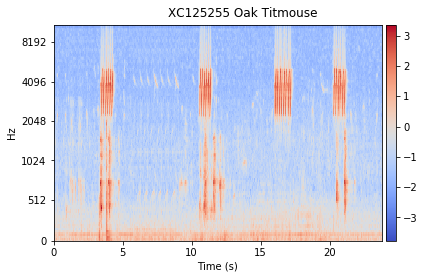

../data\audio\XC125255.mp3


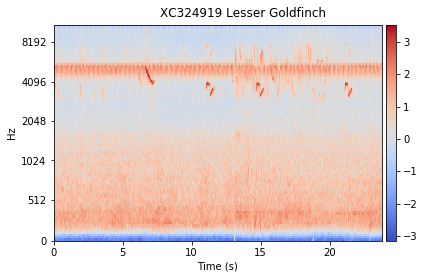

../data\audio\XC324919.mp3


In [57]:
from avian_vocalizations.visualization import show_sample
from avian_vocalizations.data import AudioFeatureGenerator

generator = AudioFeatureGenerator(X_train, y_train, data_dir=data_dir,
            batch_size=1, shuffle=True, seed=37, n_frames=1024)
Xs, ys = generator[0]
for i in range(ys.shape[0]): #for each of the samples in the batch)
    label = label_encoder.classes_[np.argmax(ys[i])]
    show_sample(Xs['melsg'][i], file_id=Xs['id'][i], 
                label=label, 
                load_clip=True, data_dir=data_dir )
    
generator.on_epoch_end()
Xs, ys = generator[0]
for i in range(ys.shape[0]): #for each of the samples in the batch)
    label = label_encoder.classes_[np.argmax(ys[i])]
    show_sample(Xs['melsg'][i], file_id=Xs['id'][i], 
                label=label, 
                load_clip=True, data_dir=data_dir )

In [52]:
model = ModelFactory(n_classes)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 64)        0         
______________________________________

In [53]:
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import ModelCheckpoint

output_dir = 'training_example_output'
n_splits = 3
n_epochs = 2
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=1/4, random_state=37)
scores = []
params = {'n_frames': 128,
          'n_classes': n_classes,
          'n_channels': 1}
for cv_train_index, cv_val_index in sss.split(X_train, y_train):
    training_generator = AudioFeatureGenerator(
        [X_train[i] for i in cv_train_index], 
        [y_train[i] for i in cv_train_index], 
        data_dir=data_dir,
        batch_size=64, shuffle=True, seed=37, **params)
    validation_generator = AudioFeatureGenerator(
        [X_train[i] for i in cv_val_index], 
        [y_train[i] for i in cv_val_index], 
        data_dir=data_dir,
        batch_size=64, **params)
    
    partial_filename = "cnn.split%02i"%len(scores)
    checkpointer = ModelCheckpoint(verbose=1, save_best_only=True,
                   filepath=os.path.join(output_dir,'weights.best.%s.hdf5'%partial_filename))
    if not os.path.exists(output_dir): os.mkdir(output_dir)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    learning = model.fit_generator(
                training_generator, 
                validation_data=validation_generator,
                epochs=n_epochs, 
                steps_per_epoch=training_generator.n_batches,
                validation_steps=validation_generator.n_batches,
                callbacks=[checkpointer], 
                #use_multiprocessing=True, workers=4,
                verbose=0, )
    history_output_file = os.path.join(output_dir,'training_history_split%i.csv'%len(scores))
    pd.DataFrame(learning.history).to_csv(history_output_file, index_label='epoch')
    acc_at_min_loss = learning.history['val_accuracy'][np.argmin(learning.history['val_loss'])]
    scores.append(acc_at_min_loss)
    print("Split %i: min loss: %.5f, accuracy at min loss: %.5f"%(
        len(scores), np.min(learning.history['val_loss']), acc_at_min_loss ))
print("Cross Validation Accuracy: mean(val_acc[argmin(val_loss)]): %.4f"%(np.mean(scores)))

ValueError: No data provided for "conv2d_1_input". Need data for each key in: ['conv2d_1_input']

## Module Versions

In [ ]:
from avian_vocalizations.toolbench import print_module_versions
print_module_versions(globals())